In [1]:
%matplotlib inline
import sys                                 
import os                                  
import numpy as np                         
import matplotlib.pyplot as plt            
                                           
                                           
caffe_root = os.environ["CAFFE_ROOT"]      
os.chdir(caffe_root)                       
print caffe_root                           
sys.path.insert(0, caffe_root + 'python')  
import caffe                  

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 23 days
Vendor:  Continuum Analytics, Inc.


/home/maohz12/pruning/


Package: mkl
Message: trial mode expires in 23 days


In [2]:
prototxt = '/home/maohz12/pruning/3_prototxt_solver/L2/train_val.prototxt'             
caffemodel = '/home/maohz12/pruning/4_model_checkpoint/alexnet/alexnet9x.caffemodel'                                                 
                                                                                          
net = caffe.Net(prototxt, caffemodel, caffe.TEST)     


fc6
(4096, 9216)


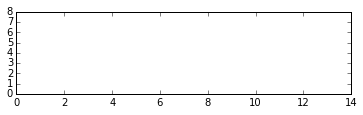

Average cycles: 54.3980034722

fc7
(4096, 4096)


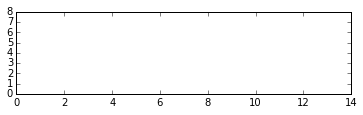

Average cycles: 56.3715820312

fc8
(1000, 4096)


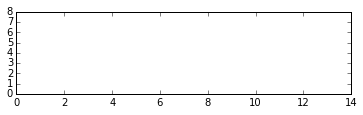

Average cycles: 38.9487304688


In [47]:
bank_number = 8
layers = ['fc6','fc7','fc8']
nonzeros_bank_layer = {}
for layer in layers:
    
    weights = net.params[layer][0].data
    print
    print"================================================="
    print layer
    print weights.shape
    
    bank_weights = np.zeros((bank_number, np.ceil(float(weights.shape[0])/bank_number), weights.shape[1]))
    
    for idx in range(bank_number):
        
        tmp = np.take(weights, range(idx, weights.shape[0], bank_number), axis=0)
        bank_weights[idx,:tmp.shape[0]] = tmp
        
    bank_nonzeros = np.zeros((bank_number, weights.shape[1]))
    
    for idx in range(bank_number):
        for time in range(weights.shape[1]):
            bank_nonzeros[idx,time] = np.count_nonzero(bank_weights[idx,:, time])
            
    nonzeros_bank_layer[layer] = np.sum(bank_nonzeros, axis=1)    
    active_banks_over_time = np.zeros((weights.shape[1], np.ceil(float(weights.shape[0])/bank_number)))
    for time in range(weights.shape[1]):
        for cycle in range(bank_weights.shape[1]):
            active_banks_over_time[time,cycle] = np.count_nonzero(bank_nonzeros[:,time] > cycle)
    
    plt.figure(figsize=(6,5)) 
    
    for i in range(1,2):
        plt.subplot(3,1,i)
        plt.xlim(0,14)
        plt.plot(active_banks_over_time[i,:])
    plt.show()
    cycles = np.zeros(weights.shape[1])
    for time in range(weights.shape[1]):
        cycles[time] = np.count_nonzero(active_banks_over_time[time])
    average_cycles = np.mean(cycles)
    print "Average cycles:", average_cycles

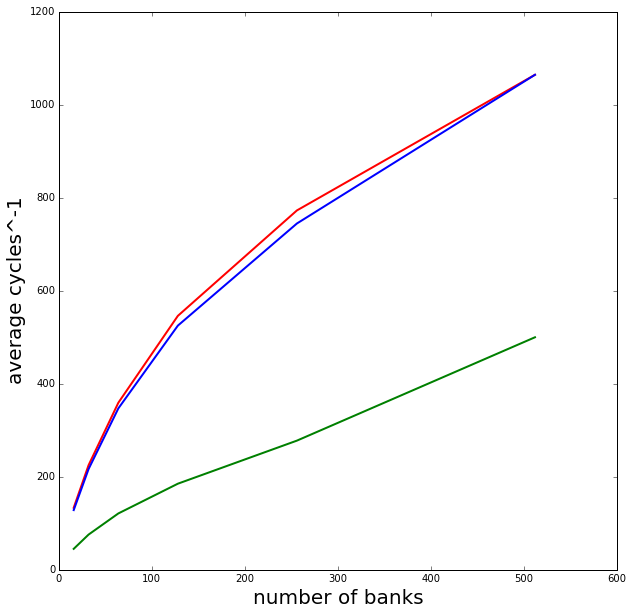

In [15]:
number_banks = np.array([16,32,64,128,256,512])
mean_cycles = np.array([[30.7,18.2,11.4,7.5,5.3,3.84754774306],
[31.9,18.9,11.8,7.8,5.5,3.84754774306],
[22.2,13.2,8.25,5.4,3.6,1.99975585938]])
color = ['r','b','g']
plt.figure(figsize=(10,10)) 
for i in range(3):
    plt.plot(number_banks, net.params[layers[i]][0].data.shape[0]/mean_cycles[i],color[i], lw=2)
    
plt.xlabel('number of banks',fontsize=20)
plt.ylabel('average cycles^-1',fontsize=20)
plt.show()

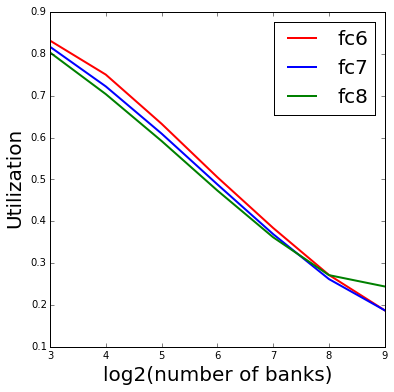

In [48]:
number_banks = np.array([8,16,32,64,128,256,512])
mean_cycles = np.array([[55.4,30.7,18.2,11.4,7.5,5.3,3.84754774306],
[56.4, 31.9,18.9,11.8,7.8,5.5,3.84754774306],
[38.9,22.2,13.2,8.25,5.4,3.6,1.99975585938]])
color = ['r','b','g']
plt.figure(figsize=(6,6)) 
line = []
compress_rate = [0.09, 0.09, 0.25]
for i in range(3):
    line.append(plt.plot(np.log(number_banks) / np.log(2), compress_rate[i]*net.params[layers[i]][0].data.shape[0]/number_banks/mean_cycles[i],color[i],lw=2)[0])
    
plt.xlabel('log2(number of banks)',fontsize=20)
plt.ylabel('Utilization',fontsize=20)
plt.legend(line, ['fc6','fc7','fc8'],fontsize=20)
plt.show()

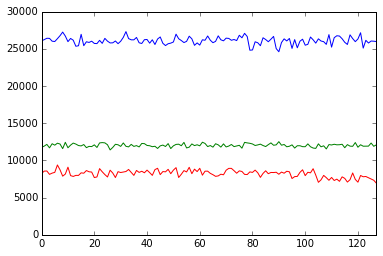

In [46]:
plt.ylim(0,30000)
plt.xlim(0,127)
for layer in layers:
    line.append(plt.plot(nonzeros_bank_layer[layer]))
# plt.legend(line, ['fc6','fc7','fc8'],fontsize=20, loc='lower center',bbox_to_anchor=(0.5, -0.3), ncol=3)

In [31]:
for layer in layers:
    print np.sum(nonzeros_bank_layer[layer])

3339037.0
1537776.0
1051264.0
